# XAI - Group activities - Activity 3

Grupo 1:
<ul>
<li>Lidia Abad Azcutia</li>
<li>Sergio Arroni del Riego</li>
<li>David González Fernández</li>
</ul>

## FIRST STEPS AND PREPROCESSING

In [1]:
#!pip install shap
#!pip install lime
#!pip install ucimlrepo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import shap
import pandas as pd
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import RandomForestClassifier

seed=0

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


https://web.archive.org/web/20231019111457/https://archive.ics.uci.edu/dataset/2/adult

In [3]:
# fetch dataset 
adult = fetch_ucirepo(id=2)  
X = adult.data.features 
y = adult.data.targets 
print(adult.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [4]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


Vemos múltiples variables categóricas. Además de codificarlas a números enteros para empelar el random forest, tendremos que imputar valores. Para ello unimos el X e y

In [5]:
dataset= pd.concat([X, y], axis=1)
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
#get number of rows
len(dataset)

48842

Miramos el los valores únicos del dataset. Vemos que hay NaNs y ?. 

In [7]:
for column in dataset.columns:
    unique_values = dataset[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for age: [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]
Unique values for workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
Unique values for fnlwgt: [ 77516  83311 215646 ... 173449  89686 350977]
Unique values for education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Unique values for education-num: [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Unique values for marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Unique values for occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-s

In [8]:
#check for NaN in case we need to impute values
nan_count_by_column = dataset.isna().sum()
print(nan_count_by_column)

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [9]:
question_mark_counts = (dataset == '?').sum()
print(question_mark_counts)

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


In [10]:
w_mode_counts = dataset['workclass'].value_counts()
w_mode_value = w_mode_counts.idxmax()
w_mode_count = w_mode_counts.max()
o_mode_counts = dataset['occupation'].value_counts()
o_mode_value = o_mode_counts.idxmax()
o_mode_count = o_mode_counts.max()
n_mode_counts = dataset['native-country'].value_counts()
n_mode_value = n_mode_counts.idxmax()
n_mode_count = n_mode_counts.max()

print("La moda de workclass es:", w_mode_value, "apareciendo un número de veces de:", w_mode_count)
print("La moda de occupation es:", o_mode_value, "apareciendo un número de veces de:", o_mode_count)
print("La moda de native-country es:", n_mode_value, "apareciendo un número de veces de:", n_mode_count)

La moda de workclass es: Private apareciendo un número de veces de: 33906
La moda de occupation es: Prof-specialty apareciendo un número de veces de: 6172
La moda de native-country es: United-States apareciendo un número de veces de: 43832


In [11]:
for col in dataset.columns:
    if dataset[col].dtype == 'O':  # Check if the column is of object type (categorical)
        mode_value = dataset[col].replace('?', np.nan).mode().iloc[0]  # Calculate the mode, treating '?' as NaN
        dataset[col] = dataset[col].replace('?', np.nan).fillna(mode_value)  # Replace '?' with the mode

#verify no NAN
nan_count_by_column = dataset.isna().sum()
print(nan_count_by_column)

#verify no '?'
question_mark_counts = (dataset == '?').sum()
print(question_mark_counts)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [12]:
#check que han sido reemplazados los nan y '?'
for column in dataset.columns:
    unique_values = dataset[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for age: [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]
Unique values for workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
Unique values for fnlwgt: [ 77516  83311 215646 ... 173449  89686 350977]
Unique values for education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Unique values for education-num: [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Unique values for marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Unique values for occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty

In [13]:
#get number of rows
len(dataset)

48842

Además de requerir codificación de las variables enteras, los valores de income deben tratarse para eliminar el . después de K puesto que hacen referencia a la misma clase con y sin el 

In [14]:
values_to_replace = {'<=50K.': '<=50K'}
dataset = dataset.replace(to_replace=values_to_replace)

In [15]:
values_to_replace = {'>50K.': '>50K'}
dataset = dataset.replace(to_replace=values_to_replace)

In [16]:
for column in dataset.columns:
    unique_values = dataset[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for age: [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]
Unique values for workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
Unique values for fnlwgt: [ 77516  83311 215646 ... 173449  89686 350977]
Unique values for education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Unique values for education-num: [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Unique values for marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Unique values for occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty

In [17]:
#ver desbalanceo
rows_with_zeros = (dataset['income'] == '<=50K')
num_rows_with_zeros = len(dataset[rows_with_zeros])
rows_with_ones = (dataset['income'] == '>50K')
num_rows_with_ones = len(dataset[rows_with_ones])

print("Number of rows with <=50K value:", num_rows_with_zeros)

print("Number of rows with >50K value:", num_rows_with_ones)

Number of rows with <=50K value: 37155
Number of rows with >50K value: 11687


Usamos LabelEncoder() para codificar a enteros las diferentes clases 

In [19]:
# turn categorical variables into integers with LabelEncoder
encoder = LabelEncoder() # Function that transform non-numeral labels into integers.
dataset.workclass= encoder.fit_transform(dataset.workclass.values)
dataset.education= encoder.fit_transform(dataset.education.values)
dataset['marital-status']= encoder.fit_transform(dataset['marital-status'].values) #problems with -
dataset.occupation= encoder.fit_transform(dataset.occupation.values)
dataset.relationship= encoder.fit_transform(dataset.relationship.values)
dataset.race= encoder.fit_transform(dataset.race.values)
dataset.sex = encoder.fit_transform(dataset.sex.values)
dataset['native-country']= encoder.fit_transform(dataset['native-country'].values)
dataset.income = encoder.fit_transform(dataset.income.values)

In [20]:
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


Representamos la correlación. Según esta matriz, las variables que aprecen más correlacionadas con el income son la edad, la educación (education-num), las relaciones, las horas por semana. También sexo y capital - gain

In [21]:
dataset.corr()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
age,1.000000,0.045643,-0.076628,-0.015058,0.030940,-0.263978,-0.000133,-0.263383,0.028421,0.088120,0.077229,0.056944,0.071558,-0.002622,0.230369
workclass,0.045643,1.000000,-0.026519,0.005219,0.007333,-0.020870,0.009841,-0.056073,0.053923,0.066672,0.031558,0.004168,0.042845,-0.004829,-0.000511
fnlwgt,-0.076628,-0.026519,1.000000,-0.022570,-0.038761,0.029851,-0.002253,0.009092,-0.027062,0.027739,-0.003706,-0.004366,-0.013519,-0.058534,-0.006339
education,-0.015058,0.005219,-0.022570,1.000000,0.359668,-0.037417,-0.035126,-0.010758,0.013250,-0.027041,0.028928,0.017638,0.057659,0.075339,0.080091
education-num,0.030940,0.007333,-0.038761,0.359668,1.000000,-0.069992,0.072706,-0.090534,0.029239,0.009328,0.125146,0.080972,0.143689,0.090137,0.332613
marital-status,-0.263978,-0.020870,0.029851,-0.037417,-0.069992,1.000000,0.030445,0.187800,-0.070104,-0.127479,-0.043969,-0.033872,-0.185567,-0.017919,-0.199072
occupation,-0.000133,0.009841,-0.002253,-0.035126,0.072706,0.030445,1.000000,-0.034964,-0.005210,0.042579,0.014518,0.011082,-0.015550,-0.001577,0.032550
relationship,-0.263383,-0.056073,0.009092,-0.010758,-0.090534,0.187800,-0.034964,1.000000,-0.117041,-0.579797,-0.056510,-0.057201,-0.250400,-0.006999,-0.253214
race,0.028421,0.053923,-0.027062,0.013250,0.029239,-0.070104,-0.005210,-0.117041,1.000000,0.086734,0.011581,0.018595,0.039694,0.117553,0.070934
sex,0.088120,0.066672,0.027739,-0.027041,0.009328,-0.127479,0.042579,-0.579797,0.086734,1.000000,0.047094,0.045480,0.228560,-0.002453,0.214628


Separamos el dataset en X e y

In [22]:
column_name = 'income'

# Find the index of the column for splitting
split_column_index = dataset.columns.get_loc(column_name)

# Create two DataFrames based on the column for splitting
X = dataset.iloc[:, :split_column_index ]
y = dataset.iloc[:, split_column_index:]

In [23]:
y.head()

,income
0,0
1,0
2,0
3,0
4,0


In [24]:
for column in y.columns:
    unique_values = y[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for income: [0 1]


In [25]:
#ver desbalanceo. checkamos que da igual que antes. 
rows_with_zeros = (y.values == 0)
num_rows_with_zeros = len(y.values[rows_with_zeros])
rows_with_ones = (y.values == 1)
num_rows_with_ones = len(y.values[rows_with_ones])

print("Number of rows with 0 value:", num_rows_with_zeros)

print("Number of rows with 1 value:", num_rows_with_ones)

Number of rows with 0 value: 37155
Number of rows with 1 value: 11687


In [26]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4


Separamos el train y test sets

In [27]:
#train test data separation
#X,y = shap.datasets.adult() # Numerical version of data. categorical turn into integers. also imput. #eliminate education (redundante with education-num) 
#fnlwgt is final weight: redundant with sex, age, race. 
X_train , X_test , y_train , y_test = train_test_split (X, y, test_size =0.2 , random_state =7)
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
42575,35,3,233533,9,13,2,11,0,4,1,0,0,42,38
2531,20,3,157599,15,10,4,7,1,4,0,0,0,25,38
42008,65,5,538099,9,13,2,4,0,4,1,0,0,30,38
21107,33,3,176185,2,8,0,2,1,4,1,0,2258,42,38
28313,28,3,204734,15,10,2,12,5,4,0,0,0,40,38


In [28]:
X_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
23509,62,3,266624,11,9,2,4,0,4,1,6418,0,40,38
38928,63,3,85420,15,10,2,11,0,4,1,5013,0,15,38
23796,30,3,361742,15,10,2,3,0,4,1,0,0,50,38
31209,35,3,29145,8,11,4,13,1,4,1,0,0,40,38
37938,34,3,113211,7,12,2,9,5,4,0,0,0,45,38


In [29]:
y_test.head()

,income
23509,1
38928,0
23796,0
31209,0
37938,1


In [30]:
len(X_test)

9769

Entrenamos el Random Forest

In [31]:
#train model RANDOM FOREST
rf = RandomForestClassifier(n_estimators=100, random_state=10) 
rf.fit( X_train.values , y_train.values.ravel())

RandomForestClassifier(random_state=10)

Predecimos y según el modelo y calculamos el MSE

In [32]:
# Predict on the test set
y_pred = rf.predict(X_test.values)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.14484594124270653


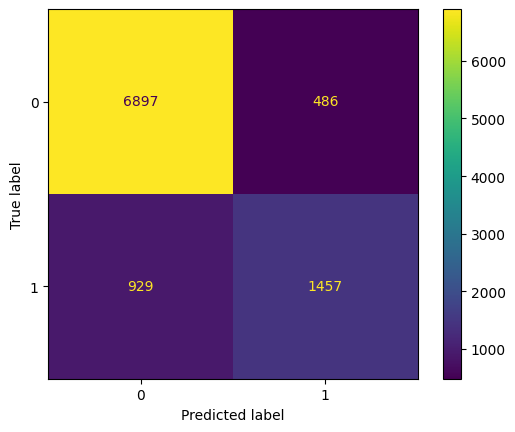

Accuracy: 0.8551540587572934
Precision: 0.7498713329902214
Recall: 0.6106454316848282
F1 score: 0.6731346731346731


In [33]:
cm = metrics.confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()
acc= accuracy_score(y_test, y_pred)
prec= precision_score(y_test, y_pred)
rec= recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 score: {f1}")

In [34]:
#exp_train and baseline definition before applying explaining methods
exp_test= X_test.values[:200]
baseline = X_test.values[-200:]

Ahora definimos los explainers y las attributions para usarlo en las diferentes secciones

In [35]:
ts_explainer = shap.TreeExplainer(rf, feature_names=X_train.columns)

In [36]:
ts_attributions = ts_explainer.shap_values(exp_test)

In [37]:
ks_explainer = shap.KernelExplainer(rf.predict, baseline, feature_names=X_train.columns)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [38]:
ks_attributions = ks_explainer.shap_values(exp_test, n_jobs=-1)

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
l_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)

In [40]:
#, feature_names=X_train.columns,  mode="classification")
lime_list=[]
for i in range(len(exp_test)):
    lime_exp = l_explainer.explain_instance(exp_test[i], rf.predict_proba, num_features=len(X_train.columns))
    lime_list.append(lime_exp.local_exp[1])
sorting=[sorted(i, key=lambda x: x[0]) for i in lime_list]
ag_lime= [[t[1] for t in sublist] for sublist in sorting]
ag_lime_attributions = np.array(ag_lime)


## SECTION A

Calcule las atribuciones locales de las 200 primeras instancias del conjunto de datos de prueba. Visualice los resultados de cada método mediante tres gráficos de resumen distintos: (shap.summary plot). A partir de estos gráficos de resumen, ¿cuáles son las características más importantes según cada método?


In the previous section we made the required installations, imports and uploads of data. Then we separated the data into train and test set and fitted the model. Here we start by defining the values of the test set that will be used as baseline and as goals of the explanation. 

Now we will use the Tree SHAP, Kernel SHAP and LIME to explain the exp_train isntances.

### Tree SHAP

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


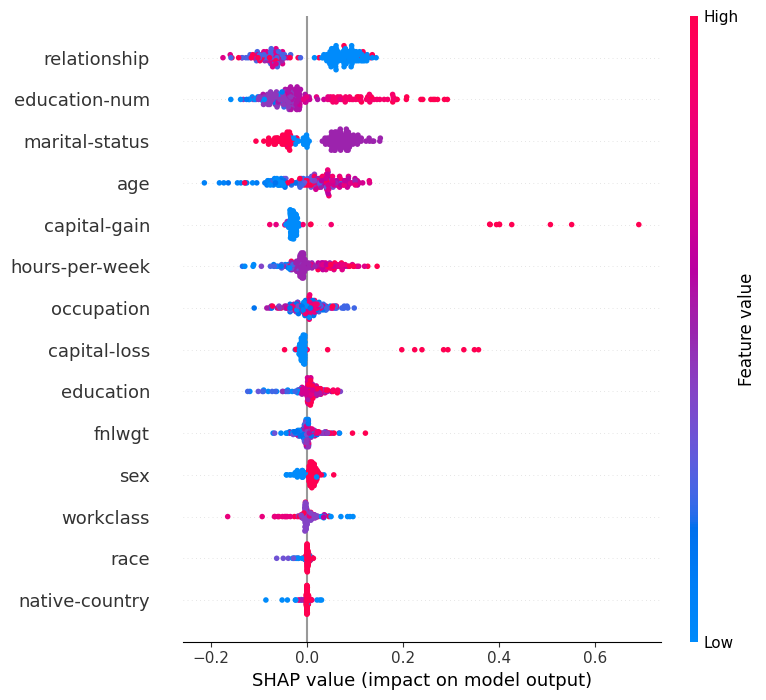

<Figure size 640x480 with 0 Axes>

In [41]:
shap.summary_plot (ts_attributions[1], exp_test, feature_names=X_train.columns)
plt.savefig('A_tree.png')
plt.show()

### Kernel SHAP

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


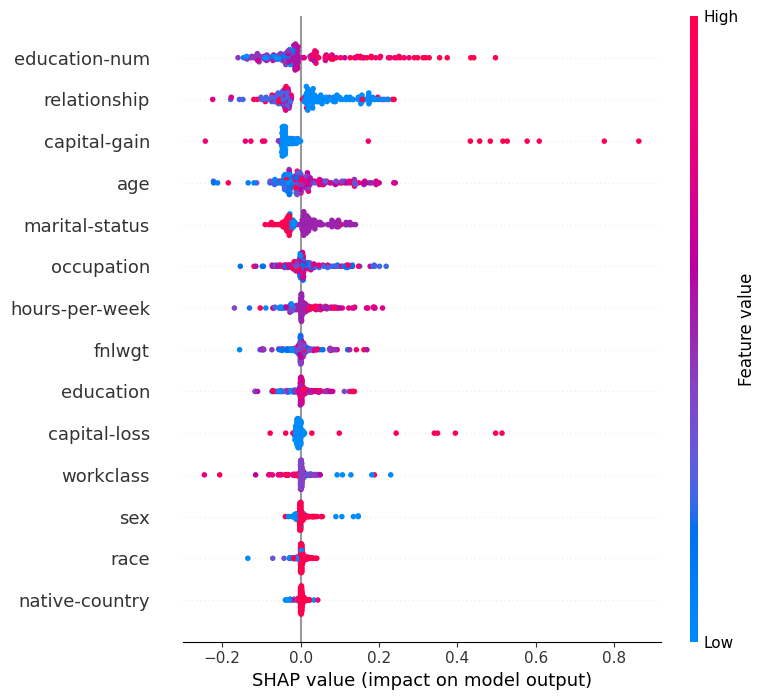

<Figure size 640x480 with 0 Axes>

In [42]:
shap.summary_plot(ks_attributions, exp_test, feature_names=X_train.columns)
plt.savefig('A_kernel.png')
plt.show()

### LIME

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


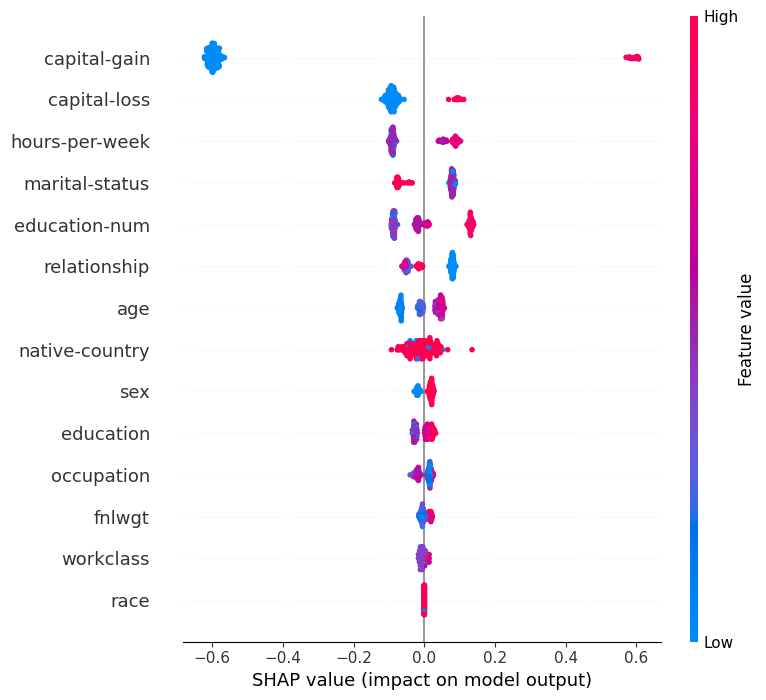

<Figure size 640x480 with 0 Axes>

In [43]:
shap.summary_plot(ag_lime_attributions, exp_test, feature_names=X_train.columns)
plt.savefig('A_lime.png')
plt.show()

## SECTION B

Visualice las atribuciones de cada método para las características "Edad" y "Horas por semana" con un gráfico de dispersión, colocando el valor de la característica en el eje x y la atribución de la característica en el eje y. Utilice la biblioteca matplotlib para generar los gráficos. Sobre la base de estos gráficos, ¿qué observaciones puede hacer sobre cómo se relacionan estas características con la predicción de ingresos del modelo?

In [44]:
#to see indexes
print(X_train.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')


### Tree SHAP

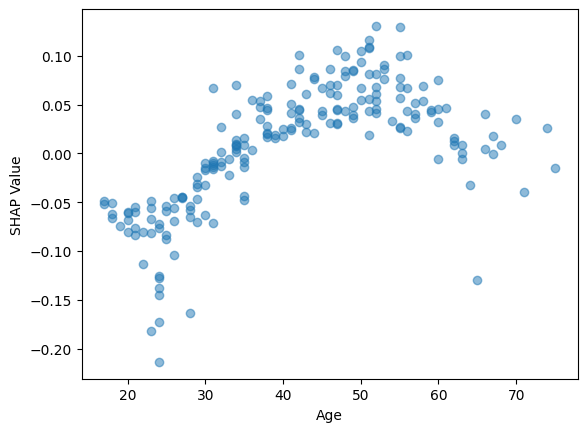

In [45]:
plt.scatter(exp_test[:, 0], ts_attributions[1][:, 0], alpha=0.5)
plt.xlabel(f"Age")
plt.ylabel("SHAP Value")
plt.show()

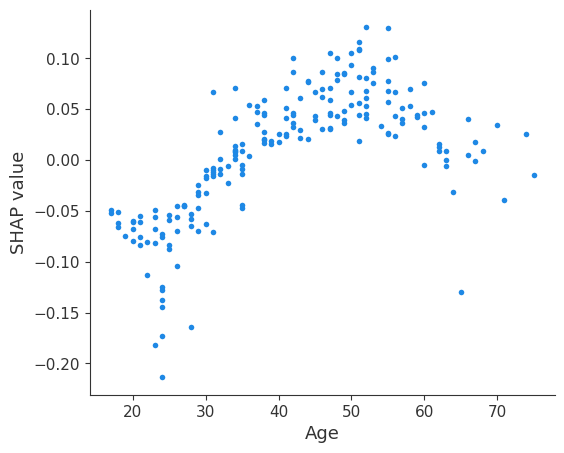

In [46]:
shap.dependence_plot(0, ts_attributions[1], exp_test, feature_names=X_train.columns, interaction_index=None, show=False)

# Customize the plot using Matplotlib
plt.xlabel(f'Age')
plt.ylabel('SHAP value')
plt.show()

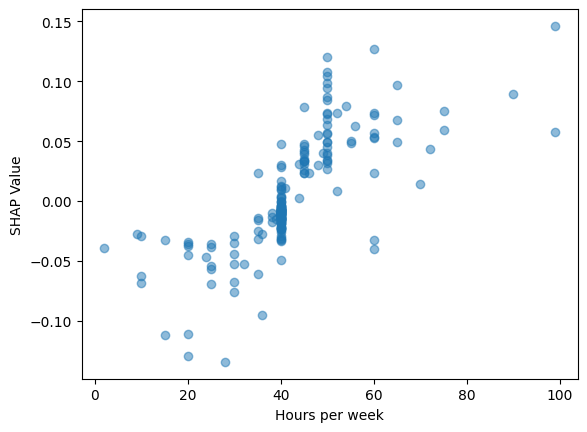

In [47]:
plt.scatter(exp_test[:, 12], ts_attributions[1][:, 12], alpha=0.5)
plt.xlabel(f"Hours per week")
plt.ylabel("SHAP Value")
plt.show()

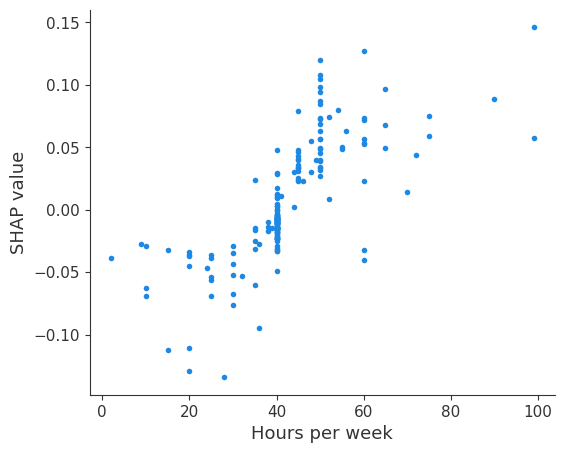

In [48]:
shap.dependence_plot(12, ts_attributions[1], exp_test, feature_names=X_train.columns, interaction_index=None, show=False)
plt.xlabel(f'Hours per week')
plt.ylabel('SHAP value')
plt.show()

### Kernel SHAP

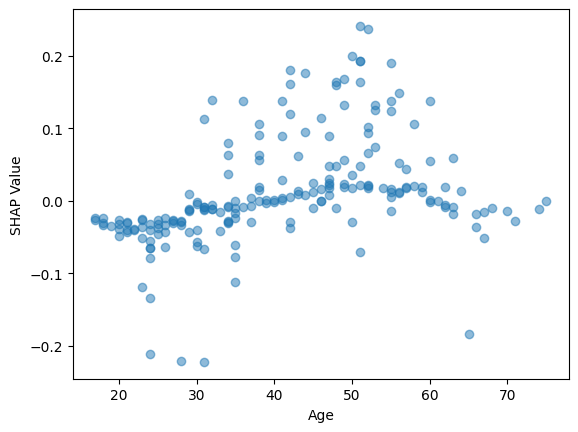

In [49]:
plt.scatter(exp_test[:, 0], ks_attributions[:, 0], alpha=0.5)
plt.xlabel(f"Age")
plt.ylabel("SHAP Value")
plt.show()

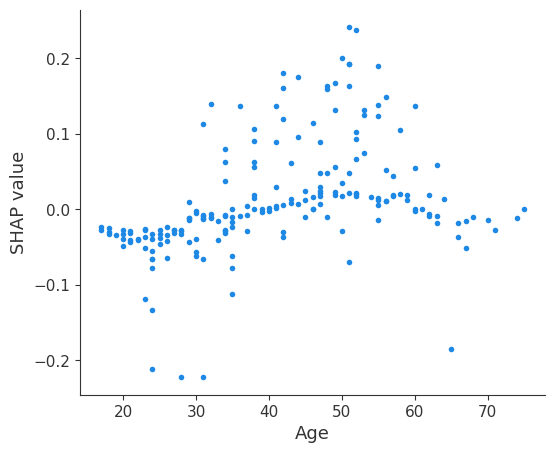

In [50]:
shap.dependence_plot(0, ks_attributions, exp_test, feature_names=X_train.columns, interaction_index=None, show=False)
plt.xlabel(f'Age')
plt.ylabel('SHAP value')
plt.show()

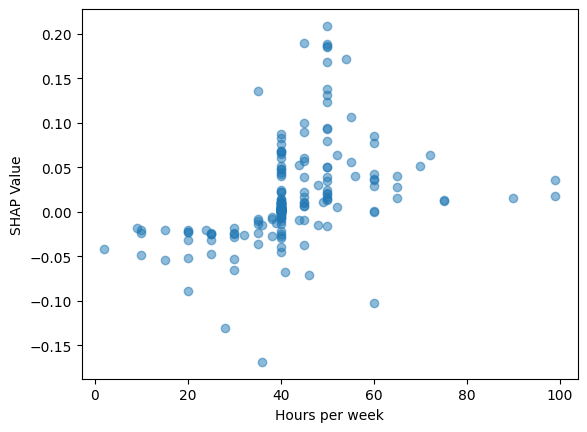

In [51]:
plt.scatter(exp_test[:, 12], ks_attributions[:, 12], alpha=0.5)
plt.xlabel(f"Hours per week")
plt.ylabel("SHAP Value")
plt.show()

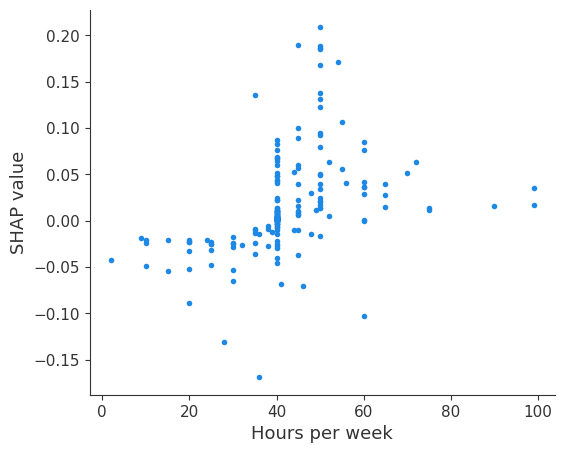

In [52]:
shap.dependence_plot(12, ks_attributions, exp_test, feature_names=X_train.columns, interaction_index=None, show=False)
plt.xlabel(f'Hours per week')
plt.ylabel('SHAP value')
plt.show()

### LIME

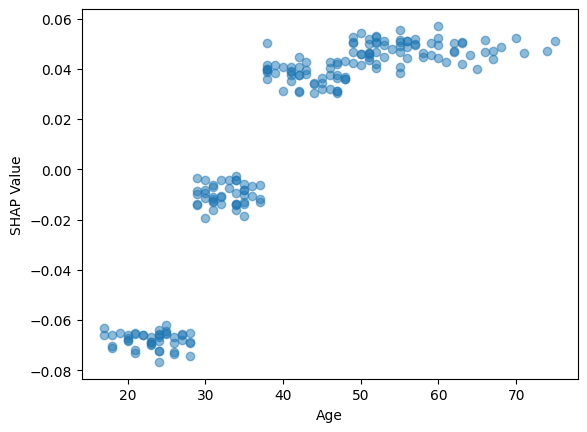

In [53]:
plt.scatter(exp_test[:, 0], ag_lime_attributions[:, 0], alpha=0.5)
plt.xlabel(f"Age")
plt.ylabel("SHAP Value")
plt.show()

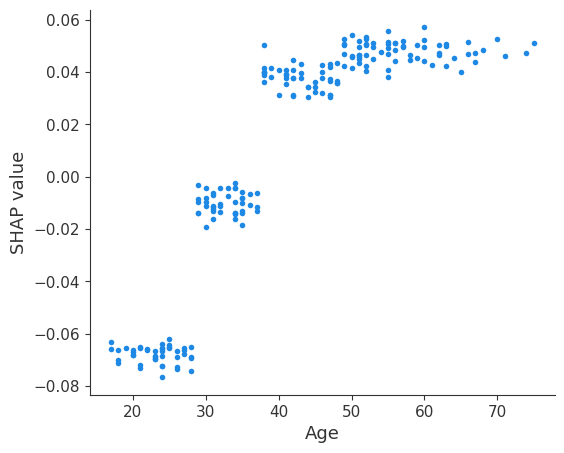

In [54]:
shap.dependence_plot(0, ag_lime_attributions, exp_test, feature_names=X_train.columns, interaction_index=None, show=False)
plt.xlabel(f'Age')
plt.ylabel('SHAP value')
plt.show()

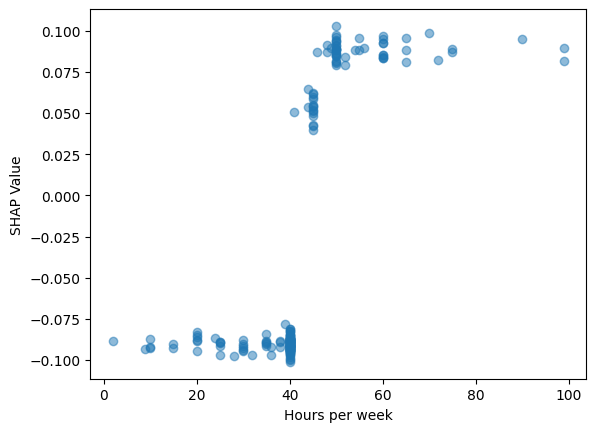

In [55]:

plt.scatter(exp_test[:, 12], ag_lime_attributions[:, 12], alpha=0.5)
plt.xlabel(f"Hours per week")
plt.ylabel("SHAP Value")
plt.show()

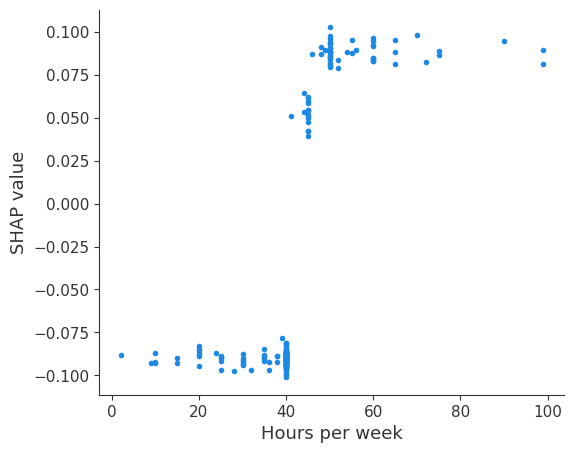

In [56]:
shap.dependence_plot(12, ag_lime_attributions, exp_test, feature_names=X_train.columns, interaction_index=None, show=False)
plt.xlabel(f'Hours per week')
plt.ylabel('SHAP value')
plt.show()

## SECTION C

Visualice las atribuciones de cada método para la muestra con índice 1 en el conjunto de prueba (X_test.iloc[1]) mediante un gráfico de barras, con los nombres de las características en el eje y y las atribuciones de las características en el eje x . A partir de las atribuciones TreeSHAP, describa una característica que contribuya de forma muy positiva a la predicción de esta muestra a la predicción de esta muestra y otra que tenga una contribución negativa importante.

In [57]:
one_row = X_test.iloc[[1]]
print(tabulate(one_row, headers='keys', tablefmt='fancy_grid'))


╒═══════╤═══════╤═════════════╤══════════╤═════════════╤═════════════════╤══════════════════╤══════════════╤════════════════╤════════╤═══════╤════════════════╤════════════════╤══════════════════╤══════════════════╕
│       │   age │   workclass │   fnlwgt │   education │   education-num │   marital-status │   occupation │   relationship │   race │   sex │   capital-gain │   capital-loss │   hours-per-week │   native-country │
╞═══════╪═══════╪═════════════╪══════════╪═════════════╪═════════════════╪══════════════════╪══════════════╪════════════════╪════════╪═══════╪════════════════╪════════════════╪══════════════════╪══════════════════╡
│ 38928 │    63 │           3 │    85420 │          15 │              10 │                2 │           11 │              0 │      4 │     1 │           5013 │              0 │               15 │               38 │
╘═══════╧═══════╧═════════════╧══════════╧═════════════╧═════════════════╧══════════════════╧══════════════╧════════════════╧════════╧══════

### Tree SHAP

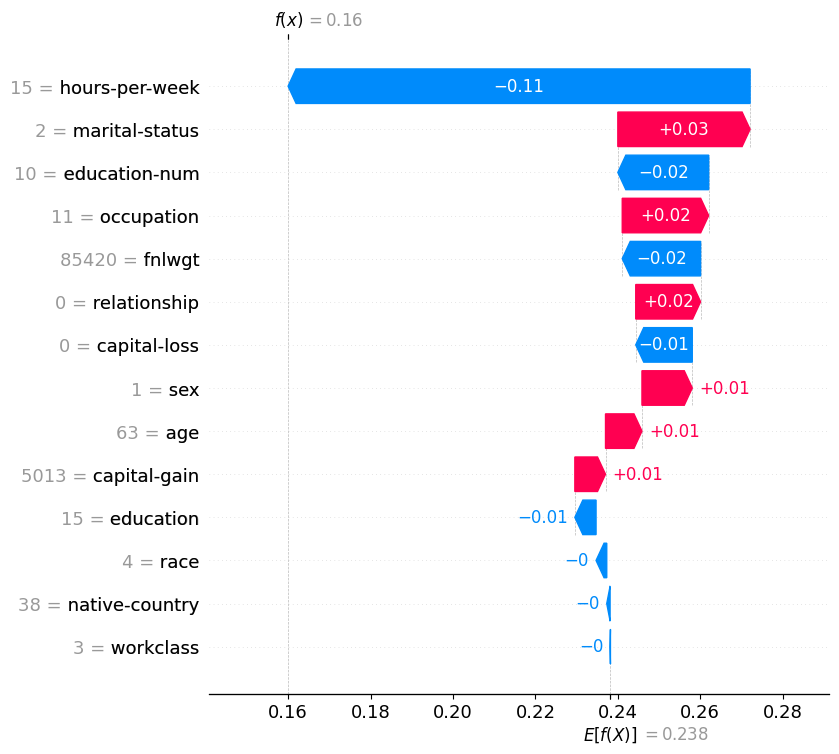

In [58]:
shap.plots.waterfall(ts_explainer(X_test)[1,:,1], max_display=len(X_train.columns))

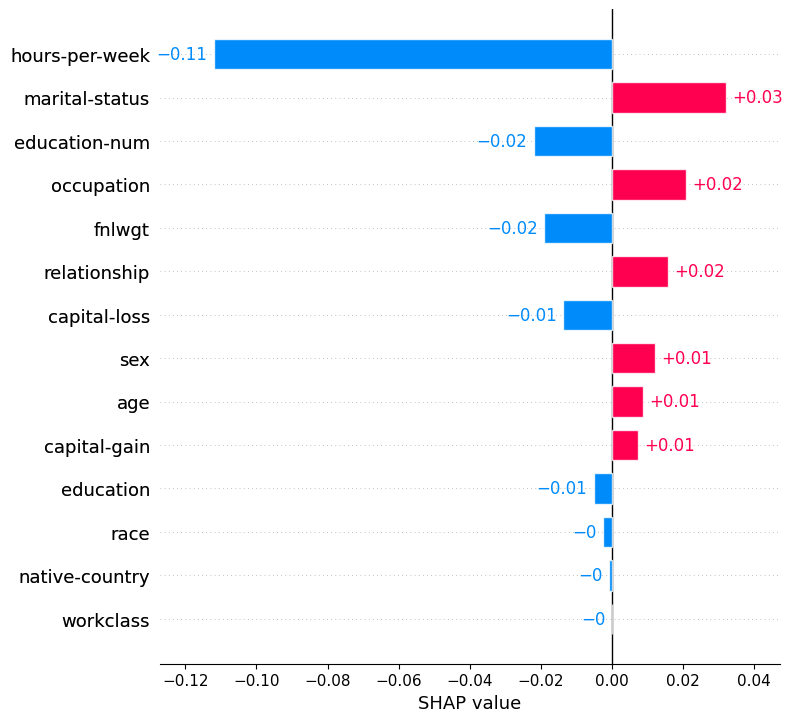

In [59]:
shap.plots.bar(ts_explainer(X_test)[1,:,1], max_display=len(X_train.columns))

Text(0, 0.5, 'Feature name')

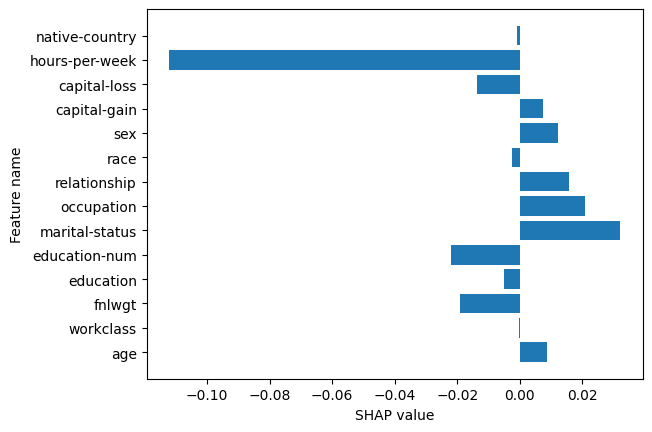

In [60]:

shap_values = ts_explainer.shap_values(X_test)[1]
plt.barh(X_test.columns, shap_values[1])
plt.xlabel("SHAP value")
plt.ylabel("Feature name")


### Kernel SHAP

  0%|          | 0/10 [00:00<?, ?it/s]

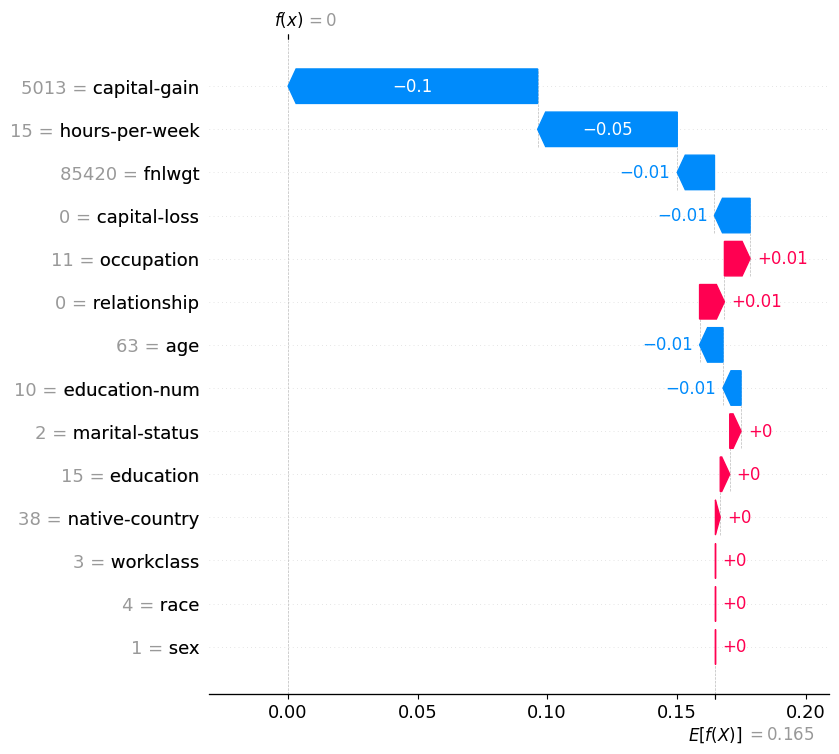

In [61]:
shap.plots.waterfall(ks_explainer(X_test)[1], max_display=len(X_train.columns))

  0%|          | 0/10 [00:00<?, ?it/s]

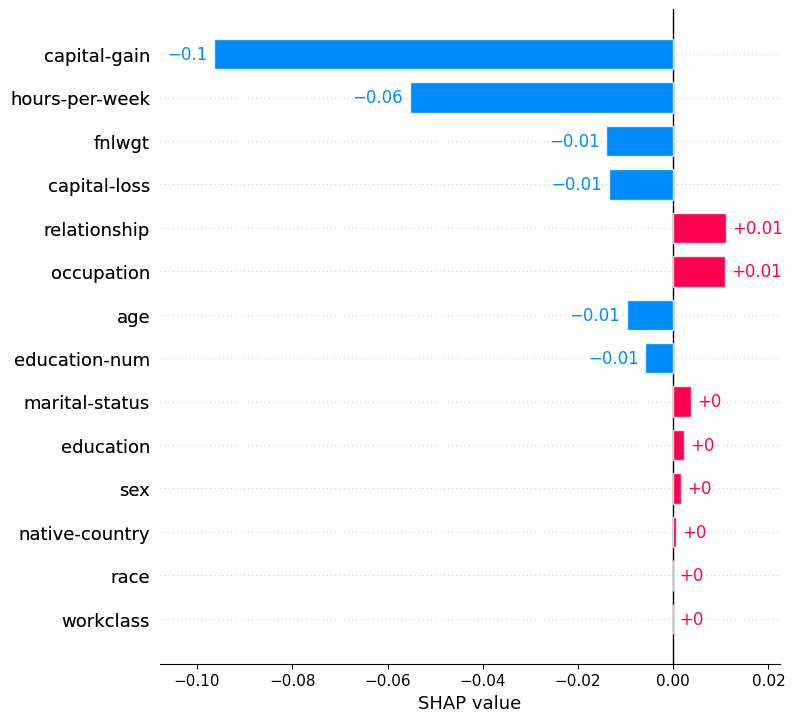

In [62]:
shap.plots.bar(ks_explainer(X_test)[1], max_display=len(X_train.columns))

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Feature name')

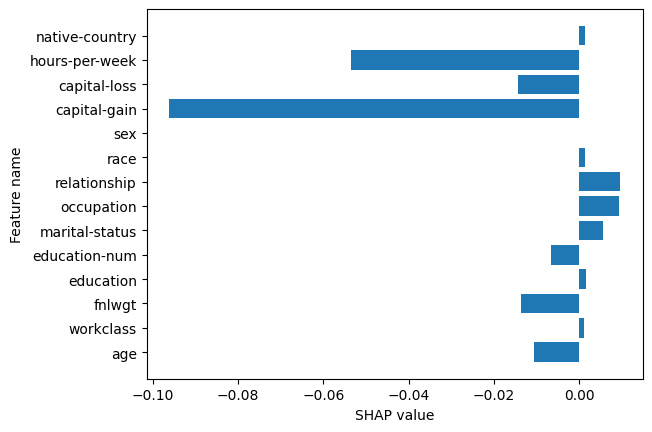

In [63]:
shap_values = ks_explainer.shap_values(X_test)
plt.barh(X_test.columns, shap_values[1])
plt.xlabel("SHAP value")
plt.ylabel("Feature name")


### LIME

In [64]:
l_attribution = l_explainer.explain_instance(X_test.values[1], rf.predict_proba, num_features=len(X_train.columns))
l_attribution.show_in_notebook(show_table=True)
l_attribution.save_to_file('lime_plot.html')

Text(0, 0.5, 'Feature name')

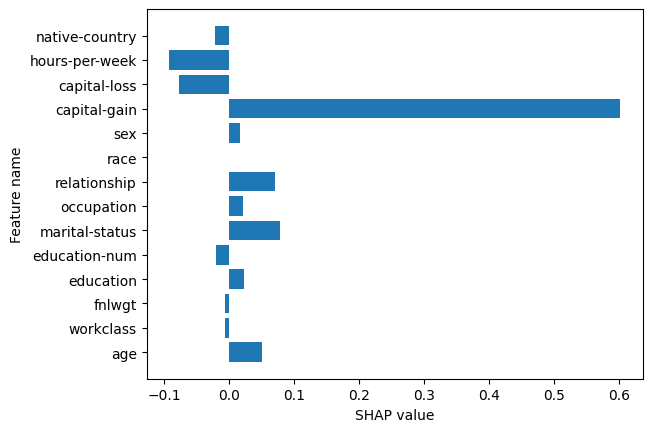

In [65]:
shap_values = ag_lime_attributions
plt.barh(X_test.columns, shap_values[1])
plt.xlabel("SHAP value")
plt.ylabel("Feature name")


## SECTION D

Un parámetro importante para KernelSHAP es el número de muestras (el argumento nsamples en la función la función shap values() de KernelExplainer). Si se utilizan más muestras, mejorará la calidad del resultado final de atribución de características, pero es más costoso. En las partes anteriores de este problema, utilizamos la configuración por defecto de este parámetro. Para investigar este parámetro, ejecute KernelSHAP2 para la muestra con índice 1 en el conjunto de prueba (X prueba.iloc[1]) con nsamples=10, nsamples=100 y nsamples=1000 para 10 ejecuciones cada uno. Una vez más, utilice un gráfico de barras para atribuciones de características locales, pero esta vez incluya barras de error para representar la desviación estándar entre ejecuciones de las atribuciones de características locales para cada número de muestras. Explique el resultado.

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.532e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.766e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.411e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.005e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.079e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.396e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.548e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.094e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.244e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.061e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.567e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.103e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.110e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.055e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.751e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.554e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.266e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.099e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.097e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.096e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.330e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.665e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.380e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=2.161e-02, previous alpha=7.103e-03, with an active set of 6 regressors.
Regressors in active set degenerate. Dropping a regressor, after 3 iteration

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.698e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.825e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.811e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=1.736e-02, previous alpha=1.736e-02, with an active set of 8 regressors.
Regressors in active set degenerate. Dropping a regressor, after 2 iterat

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.047e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.375e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.375e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.703e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.706e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.294e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.150e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.403e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a 

  0%|          | 0/10 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.793e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.965e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.965e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.059e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues ar

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

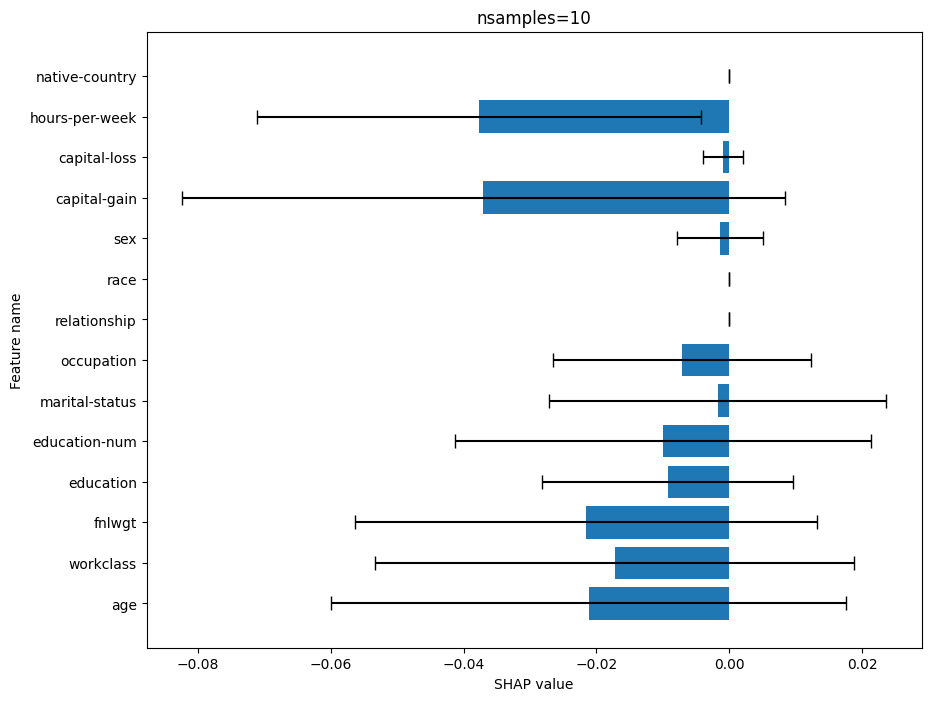

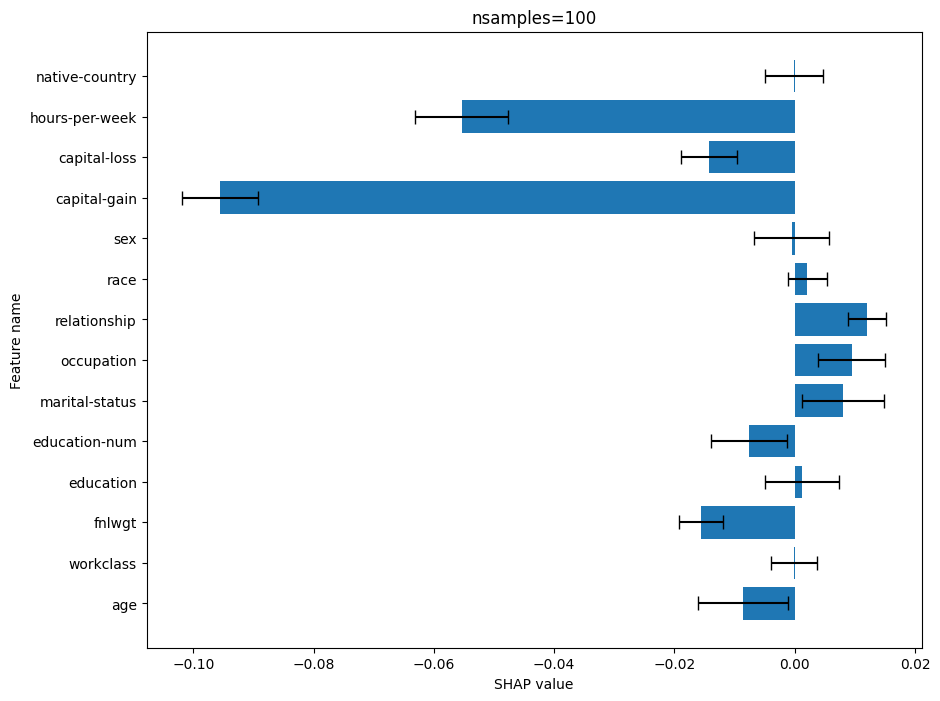

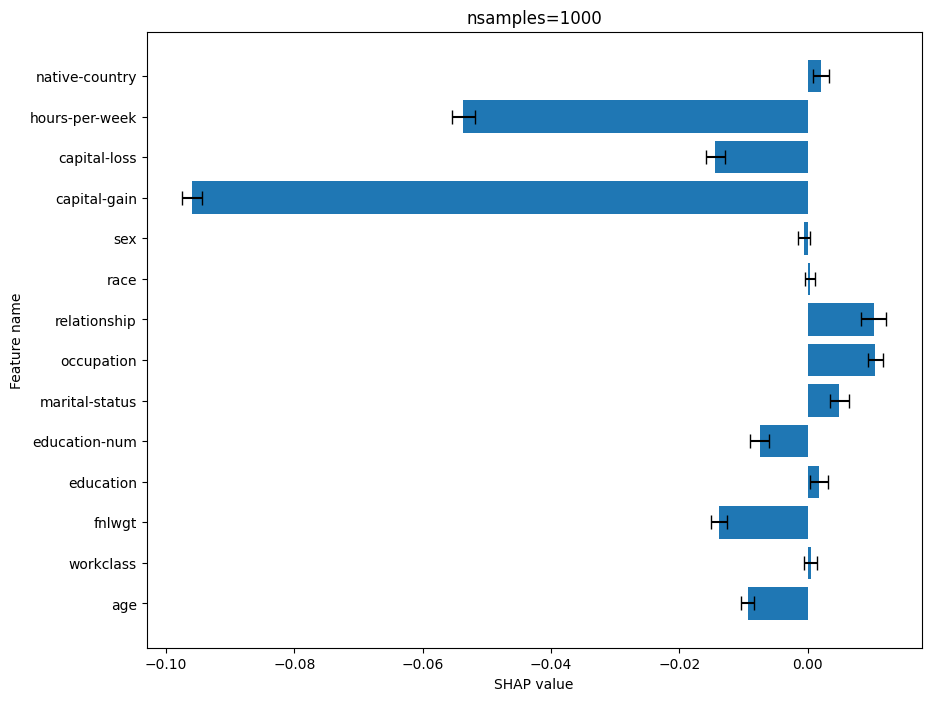

In [66]:
# Define the number of iterations
num_iterations = 10

# Define nsamples values
nsamples_values = [10, 100, 1000]
shap_values_dict = {}
for nsamples in nsamples_values:
    shap_values_iterations = []
    for iteration in range(num_iterations):
        newks_att = ks_explainer.shap_values(X_test, n_jobs=-1, nsamples=nsamples)
        shap_values_iterations.append(newks_att)
    

    mean_shap_values = np.mean(shap_values_iterations, axis=0)
    std_shap_values = np.std(shap_values_iterations, axis=0)
    
    shap_values_dict[nsamples] = {'mean': mean_shap_values, 'std': std_shap_values}

feature_names = X_train.columns
# Plotting bar plots with error bars
for nsamples, values in shap_values_dict.items():
    mean_values = values['mean']
    std_values = values['std']

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(feature_names, mean_values[1], xerr=std_values[1], capsize=5)
    ax.set_title(f"nsamples={nsamples}")
    ax.set_xlabel("SHAP value")
    ax.set_ylabel("Feature name")
    plt.savefig(f'D_{nsamples}.png')
    plt.show()
